Before getting started, this is my first kernel, please give it an upvote if you like it. Thans in advance.
#### Competition description:
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.



## We will follow the below steps, let's get started
##### 1. Target variable distribution
##### 2. Feature visualization with Target variable
##### 3. Missing Value imputation
##### 4. Fix Skewed features
##### 5. Feature Creation
##### 6. Feature Transformation
##### 7. Training a model
##### 8 . Prediction
##### 9. Submission


In [46]:
from datetime import datetime
from scipy.stats import skew,norm  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats
from scipy import stats
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

#ML Algoirthm
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor

In [47]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_size = train.shape[0]
submission = pd.read_csv("sample_submission.csv")

import warnings
warnings.filterwarnings(action="ignore")

#### 1.Target Variable Distribution
Our first step in Machine Learning should always be analyzing the target variable. Saleprice is our given target/dependent variable. Let's analyse its distribution

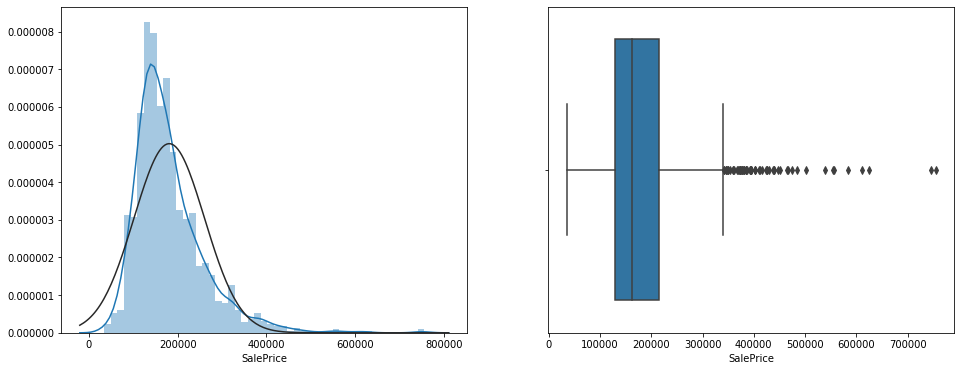

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
--------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [48]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train['SalePrice'],fit=norm,ax=ax[0])
sns.boxplot(train['SalePrice'])
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))
print("--------------------------------------")
print(train['SalePrice'].describe())

##### Observations:
- Target variable is not normally distributed.
- It is rightly skewed. 
- Average sell price is 180921 USD which pulled towards outliers values at the upper end.
- Median 163000 USD which is lower than Mean value.
- It has couple of outliers at the upper end.

#### 2.Feature visualization with Target variable

Let's analyse how the other independent/predictor/input variable correleated with the Target variable

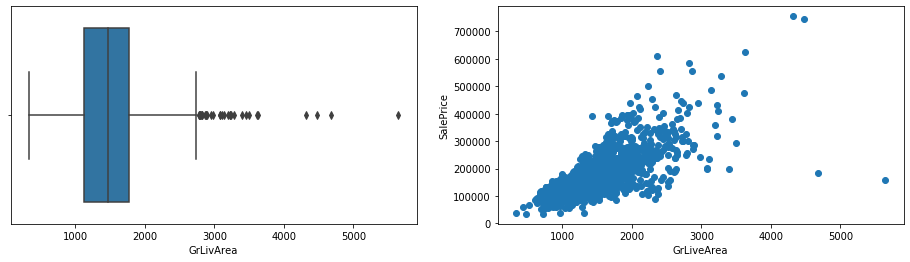

In [49]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()


In [50]:
train.drop(train[train['GrLivArea']>4500].index,axis=0,inplace=True)

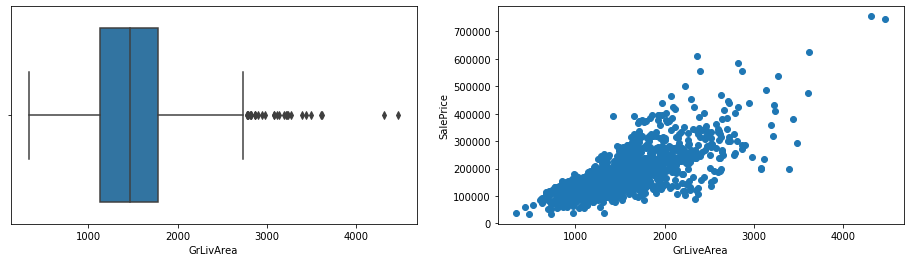

In [51]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

In [52]:
# # Finding numeric features
# numeric_cols = train.select_dtypes(exclude='object').columns
# numeric_cols_length = len(numeric_cols)  

# fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
# plt.subplots_adjust(right=2)
# plt.subplots_adjust(top=2)

# # skiped Id and saleprice feature
# for i in range(1,numeric_cols_length-1):
#     feature = numeric_cols[i]
#     plt.subplot(numeric_cols_length, 3, i)
#     sns.scatterplot(x=feature, y='SalePrice', data=train)
#     plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
#     plt.ylabel('SalePrice', size=15, labelpad=12.5)
           
# plt.show()


##### Observations:

- MSSubClass,MoSold,YrSold - patterns shows it as a category and description meant the same
- OverallQual, OverallCond - Ordered value (like ratings)
- BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Fireplaces,BedroomAbvGr,KitchenAvbGr - discrete value(no. of bathrooms)

- OutlierAnalysis - Looks there is an outlier on the 
    - LotFrontage, LotArea,BsmtFinSF1,LowQualFinSF,1stFlrSF,TotRmsAbvGrd,EnclosedPorch


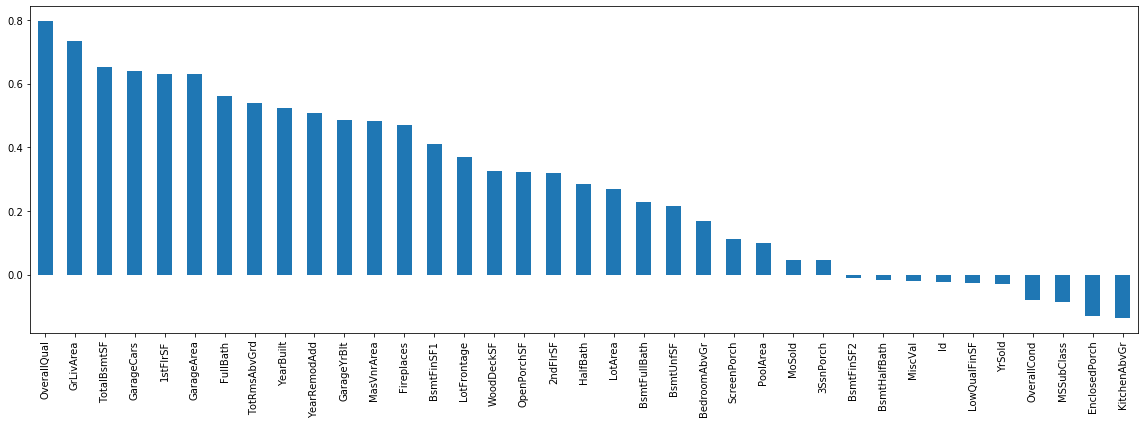

In [53]:
corr = train.select_dtypes(include='number').corr()
plt.figure(figsize=(16,6))
corr['SalePrice'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.tight_layout()

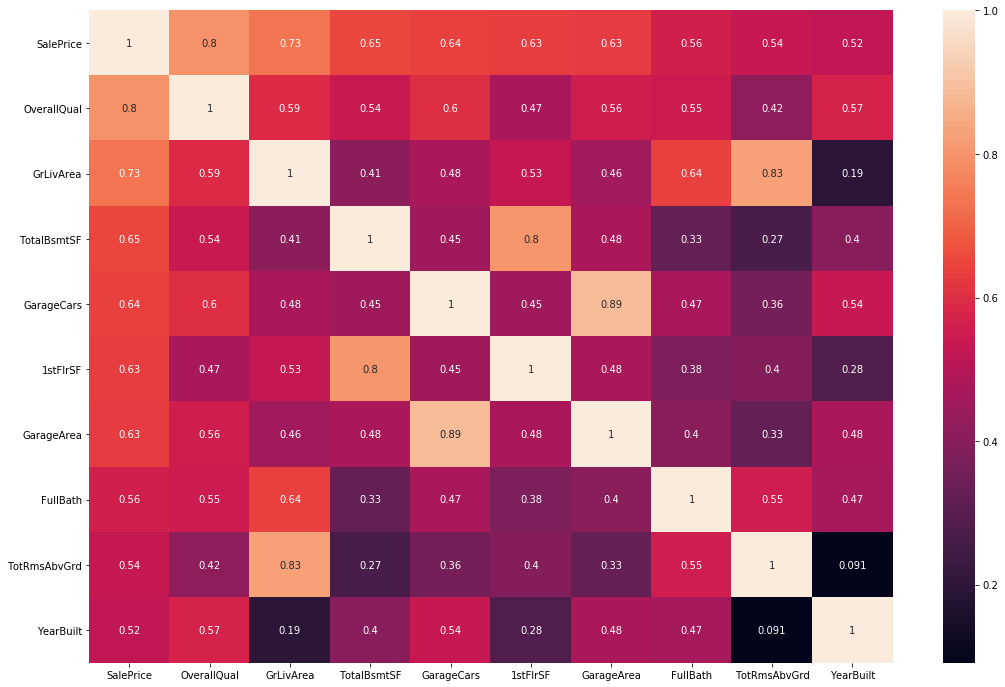

In [54]:
# Correlation of top 10 feature with saleprice
corWithSalePrice = train.corr().nlargest(10,'SalePrice')['SalePrice'].index
f , ax = plt.subplots(figsize = (18,12))
ax = sns.heatmap(train[corWithSalePrice].corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

##### Observations

- OverallQual, GrLivArea , GarageCars , GarageArea and TotalBsmtSF are strongly correlated with the SalePrice.
- GarageCas and GarageArea are strongly correlated this is because of parking the Garage cars at the GarageArea.
- TotRmsAbvGrd and GrLivArea are strongly correleated. When the Ground area increases count of rooms also increases.
- TotalBsmtSF and 1stFlrSF are strongly correleated.

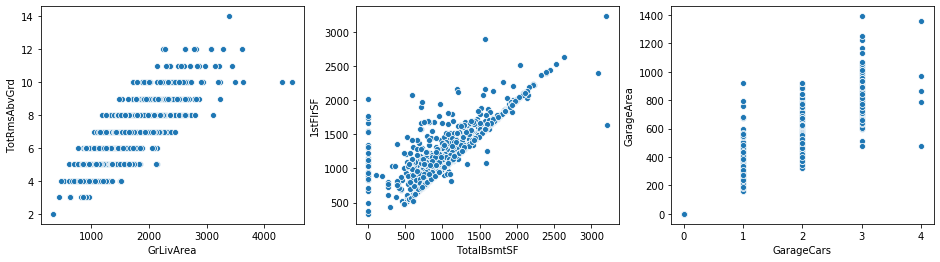

In [55]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot('GrLivArea','TotRmsAbvGrd',data=train,ax=ax[0])
sns.scatterplot('TotalBsmtSF','1stFlrSF',data=train,ax = ax[1])
sns.scatterplot('GarageCars','GarageArea',data=train,ax = ax[2])
plt.show()

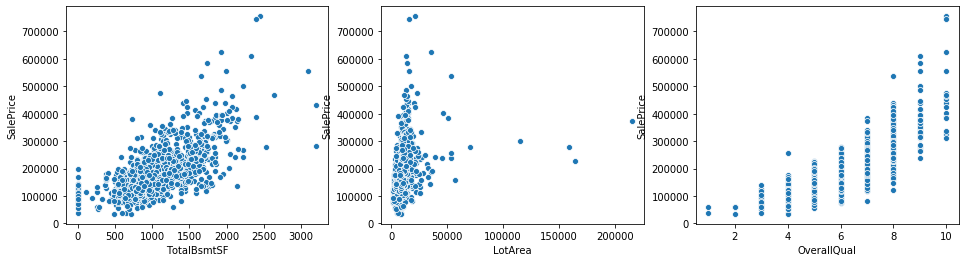

In [56]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot(x='TotalBsmtSF', y='SalePrice',data=train,ax=ax[0])
sns.scatterplot(x='LotArea', y='SalePrice',data=train,ax=ax[1])
sns.scatterplot(x='OverallQual', y='SalePrice',data=train,ax=ax[2])
plt.show()


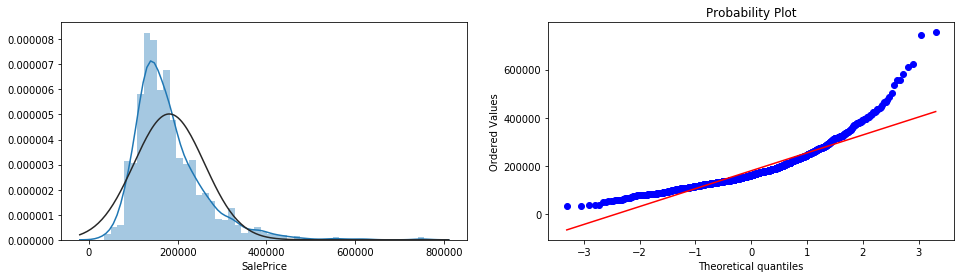

Skewness: 1.8812964895244009
Kurtosis: 6.523066888485879


In [57]:
# After removing the two outliers, you can see that skewness is reduced. Still Saleprice is not normally distributed.
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(train['SalePrice'],ax=ax[0],fit=norm)
stats.probplot(train['SalePrice'],plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))

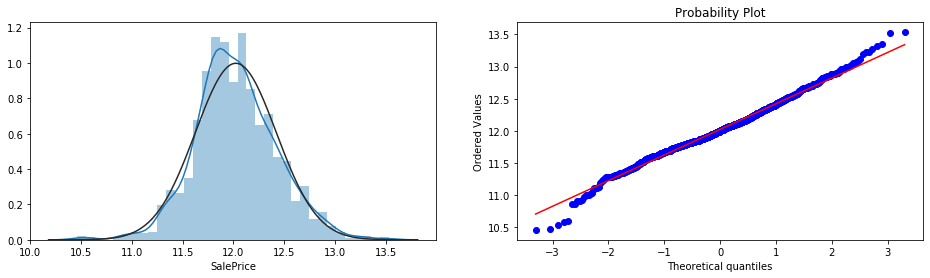

Skewness: 0.12157976050304882
Kurtosis: 0.8047507917418972


In [58]:
#Log- transformation
y = np.log1p(train['SalePrice'])

f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(y.skew()))
print("Kurtosis: {}".format(y.kurt()))

In [59]:
train_labels = y
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [60]:
all_features.drop('Id',inplace=True,axis=1)
all_features.shape

(2917, 79)

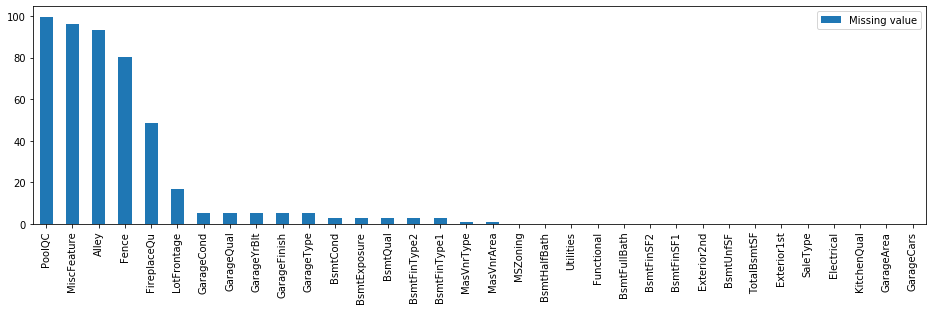

In [61]:
#### 3.Imputing missing values

#visualize missing data
missing_value = all_features.isnull().sum().sort_values(ascending=False) / len(all_features) * 100
missing_value = missing_value[missing_value != 0]
missing_value = pd.DataFrame({'Missing value' :missing_value,'Type':missing_value.index.map(lambda x:all_features[x].dtype)})
missing_value.plot(kind='bar',figsize=(16,4))
plt.show()

In [62]:
print("Total No. of missing value {} before Imputation".format(sum(all_features.isnull().sum())))
def fill_missing_values():
    
    all_features['Functional'] = all_features['Functional'].fillna('Typ')
    
    fillSaleType = all_features[all_features['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
    all_features['SaleType'].fillna(fillSaleType,inplace=True)

    fillElectrical = all_features[all_features['Neighborhood']=='Timber']['Electrical'].mode()[0]
    all_features['Electrical'].fillna(fillElectrical,inplace=True)

    exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
    fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior1st'].fillna(fillExterior1,inplace=True)

    exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
    fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)

    bsmtNeigh = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
    fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
    all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

    kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
    fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
    all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)
        
    all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
       
    all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2','PoolQC']:
        all_features[col] = all_features[col].fillna('None')
    
    categorical_cols =  all_features.select_dtypes(include='object').columns
    all_features[categorical_cols] = all_features[categorical_cols].fillna('None')
    
    numeric_cols = all_features.select_dtypes(include='number').columns
    all_features[numeric_cols] = all_features[numeric_cols].fillna(0)

fill_missing_values()

print("Total No. of missing value {} after Imputation".format(sum(all_features.isnull().sum())))

Total No. of missing value 13958 before Imputation
Total No. of missing value 0 after Imputation


In [63]:
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [64]:
#### 4. Fix Skewed features

# converting some numeric features to string
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)


# Filter the skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [65]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [66]:
### 5. Feature Creation

# houseAge = all_features['YrSold'].astype(int) - all_features['YearBuilt']
# rebuildAge = all_features['YearRemodAdd'] - all_features['YearBuilt'] 
# f,ax = plt.subplots(1,2,figsize=(12,8))
# # We can see that new house is selling at the higher price 
# all_features['HseAgeBin'] = pd.cut(houseAge.astype(int), 5)
# all_features['HseAgeBin'].value_counts().plot(kind='bar',ax=ax[0])
# ax[0].set_xlabel('House Age')


# all_features['HseRebuildBin'] = pd.cut(rebuildAge.astype(int), 5)
# all_features['HseRebuildBin'].value_counts().plot(kind='bar')
# ax[1].set_xlabel('Time taken to Rebuild')
# plt.show()

# all_features['MoSoldBin'] = pd.cut(all_features['MoSold'].astype(int), 4)
# ax = all_features['MoSoldBin'].value_counts().plot(kind='bar')
# ax.set_xlabel('Month sold Bin')
# plt.show()




In [67]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')

all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)





# all_features['TotalSF1'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
# all_features['TotalSF2'] = all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

In [68]:
all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1

In [69]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)


In [70]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

# squared_features = ['YearRemodAdd', 'LotFrontage_log', 
#               'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
#               'GarageCars_log', 'GarageArea_log']

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log']

all_features = squares(all_features, squared_features)

In [71]:
# #### 6. Feature Transformation
# # few categories are ordered in nature, so converting them to numbers gives more meaning
# quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
# quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
# for col in quality_cols:
#     all_features[col] = all_features[col].replace(quality_map)

# all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

# all_features["PavedDrive"] =all_features["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

# bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
# bsmt_col = ['BsmtFinType1','BsmtFinType2']
# for col in bsmt_col:
#     all_features[col] = all_features[col].replace(bsmt_ratings)

    
# # all_features["OverallScore"]   = all_features["OverallQual"] * all_features["OverallCond"]
# # all_features["GarageScore"]    = all_features["GarageQual"] * all_features["GarageCond"]
# # all_features["ExterScore"]     = all_features["ExterQual"] * all_features["ExterCond"]
# # all_features["KitchenScore"]   = all_features["KitchenAbvGr"] * all_features["KitchenQual"]
# # all_features["FireplaceScore"] = all_features["Fireplaces"] * all_features["FireplaceQu"]
# # all_features["GarageScore"]    = all_features["GarageArea"] * all_features["GarageQual"]
# # all_features["PoolScore"]      = all_features["PoolArea"] * all_features["PoolQC"]

In [72]:
# label = LabelEncoder()
# all_features['HseAgeBin'] = label.fit_transform(all_features['HseAgeBin']).astype(str)
# all_features['HseRebuildBin'] = label.fit_transform(all_features['HseRebuildBin']).astype(str)
# all_features['MoSoldBin'] = label.fit_transform(all_features['MoSoldBin']).astype(str)
# all_features.drop(['1stFlrSF' , 'TotRmsAbvGrd' , 'GarageArea'],axis=1,inplace=True)
# all_features.drop()
all_features = pd.get_dummies(all_features).reset_index(drop=True)

In [73]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [74]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
train_labels = train_labels.drop(y.index[outliers])


In [75]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 98:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)
print(overfitted_features)
X = X.drop(overfitted_features, axis=1)
X_test = X_test.drop(overfitted_features, axis=1)

['LowQualFinSF', '3SsnPorch', 'PoolArea', 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'Has3SsnPorch', 'LowQualFinSF_log', '3SsnPorch_log', 'PoolArea_log', 'MSSubClass_150', 'MSSubClass_180', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_75', 'MSSubClass_85', 'MSZoning_C (all)', 'MSZoning_RH', 'LotShape_IR3', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMa

In [79]:
len(overfitted_features)

124

In [819]:
X.shape, train_labels.shape, X_test.shape

((1453, 370), (1453,), (1459, 370))

In [820]:
#### 7. Train a model
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [821]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [822]:
# # Light Gradient Boosting Regressor
# lightgbm = LGBMRegressor(objective='regression', 
#                        num_leaves=6,
#                        learning_rate=0.01, 
#                        n_estimators=7000,
#                        max_bin=200, 
#                        bagging_fraction=0.8,
#                        bagging_freq=4, 
#                        bagging_seed=8,
#                        feature_fraction=0.2,
#                        feature_fraction_seed=8,
#                        min_sum_hessian_in_leaf = 11,
#                        verbose=-1,
#                        random_state=42)

# # XGBoost Regressor
# xgboost = XGBRegressor(learning_rate=0.01,
#                        n_estimators=6000,
#                        max_depth=4,
#                        min_child_weight=0,
#                        gamma=0.6,
#                        subsample=0.7,
#                        colsample_bytree=0.7,
#                        objective='reg:linear',
#                        nthread=-1,
#                        scale_pos_weight=1,
#                        seed=27,
#                        reg_alpha=0.00006,
#                        random_state=42)

# # Ridge Regressor
# ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# # Gradient Boosting Regressor
# gbr = GradientBoostingRegressor(n_estimators=6000,
#                                 learning_rate=0.01,
#                                 max_depth=4,
#                                 max_features='sqrt',
#                                 min_samples_leaf=15,
#                                 min_samples_split=10,
#                                 loss='huber',
#                                 random_state=42)  

# # Random Forest Regressor
# rf = RandomForestRegressor(n_estimators=1200,
#                           max_depth=15,
#                           min_samples_split=5,
#                           min_samples_leaf=5,
#                           max_features=None,
#                           oob_score=True,
#                           random_state=42)

# # Stack up all the models above, optimized using xgboost
# stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)

In [823]:
# scores = {}

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['lgb'] = (score.mean(), score.std())

In [824]:
# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['xgb'] = (score.mean(), score.std())

In [825]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())

SVR: 0.1011 (0.0131)


In [826]:
all_features.shape

(2917, 374)

In [827]:
# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())


In [828]:
# score = cv_rmse(rf)
# print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['rf'] = (score.mean(), score.std())

In [829]:
# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['gbr'] = (score.mean(), score.std())


In [830]:
# print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [831]:
# print('lightgbm')
# lgb_model_full_data = lightgbm.fit(X, train_labels)

In [832]:
# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, train_labels)

In [833]:
# print('Svr')
svr_model_full_data = svr.fit(X, train_labels)


In [834]:
# print('Ridge')
# ridge_model_full_data = ridge.fit(X, train_labels)

In [835]:
# print('RandomForest')
# rf_model_full_data = rf.fit(X, train_labels)

In [836]:
# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, train_labels)

In [837]:
# # Blend models in order to make the final predictions more robust to overfitting
# def blended_predictions(X):
#     return ((0.1 * ridge_model_full_data.predict(X)) + \
#             (0.2 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.05 * rf_model_full_data.predict(X)) + \
#             (0.35 * stack_gen_model.predict(np.array(X))))

In [838]:
# # Get final precitions from the blended model
# blended_score = rmsle(train_labels, blended_predictions(X))
# scores['blended'] = (blended_score, 0)
# print('RMSLE score on train data:')
# print(blended_score)

In [839]:
# ### 8. Predictions

# # Read in sample_submission dataframe
# submission = pd.read_csv("sample_submission.csv")
# submission.shape

In [840]:
# # Append predictions from blended models
# submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [841]:
# # Fix outleir predictions
# q1 = submission['SalePrice'].quantile(0.0045)
# q2 = submission['SalePrice'].quantile(0.99)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
# submission.to_csv("submission_regression1.csv", index=False)

In [842]:
# ### 9. Submission

# submission['SalePrice'] *= 1.001619
# submission.to_csv("submission_regression2.csv", index=False)

In [843]:
a = 10
a

10